In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import cartopy.feature
import matplotlib.path as mpath
import cmasher as cmr

# Define a function to make figures only showing the Southern Ocean between south of 40S
def axku(ax1):
    ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)

In [3]:
# Read phytoplankton files

files=['ALLPHY_mnclim.nc','ALLPHY_antentok.nc','ALLPHY_asmalltok.nc','ALLPHY_feplig.nc']


fracp=[]
fracn=[]
fracd=[]

phyns=[]
phyds=[]
phyps=[]

allfracs=[]
for f in files:
    ds= xr.open_dataset(f)
    
    phy= ds['ALLPHY'].sel(deptht=4.999938e+00).where(ds['nav_lat']<-40).compute()
    phyn= ds['PHY'].sel(deptht=4.999938e+00).where(ds['nav_lat']<-40).compute()
    phyd= ds['PHY2'].sel(deptht=4.999938e+00).where(ds['nav_lat']<-40).compute()
    phyp= ds['PIC'].sel(deptht=4.999938e+00).where(ds['nav_lat']<-40).compute()
    
    phyns.append(phyn)
    phyps.append(phyp)
    phyds.append(phyd)
    
    # calculate total fraction:
    fracn1= phyn/phy
    fracd1= phyd/phy
    fracp1= phyp/phy
    
    allfracs.append([fracd1,fracn1,fracp1])
    
    fracn.append(fracn1)
    fracd.append(fracd1)
    fracp.append(fracp1)
    

In [4]:
# calculate Mn deficiency 

filepmn=['ALLPMN_mnclim.nc', 'PMN_antentok.nc','PMN_asmalltok.nc','PMN_feplig.nc']
filemmu=['Mu_mnclim.nc', 'Mu_antentok.nc','Mu_asmalltok.nc','Mu_feplig.nc']
filechl=['ALLCHL_mnclim.nc', 'ALLCHL_antentok.nc','ALLCHL_asmalltok.nc','ALLCHL_feplig.nc']

mnchln=[4.97e-6, 2.24e-6, 9.94e-6, 4.97e-6]

chlns=[]
chlds=[]
chlps=[]

chlcs=[]

blurbs=[]

mus=[]
mndefs=[]

pmn=[]
pmd=[]
pmp=[]

qmnreqns=[]
qmnreqds=[]
qmnreqps=[]

for f in range(len(filechl)):
    
    dsc= xr.open_dataset(filechl[f])
    dsm= xr.open_dataset(filemmu[f])
    dsp= xr.open_dataset(filepmn[f])
    print(f)
    
    chln= dsc['NCHL'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    chld= dsc['DCHL'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    chlp= dsc['PCHL'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    
    mun= dsm['MuN'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    mup= dsm['MuP'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    mud= dsm['MuD'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    
    mus.append([mud,mun,mup])
    
    pmns= dsp['MNN'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    pmds= dsp['MND'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()
    pmps= dsp['MNPI'].sel(deptht=4.999938e+00).where(dsc['nav_lat']<-40).compute()


    qmnreqn= (mnchln[f] * (chln/phyns[f]))
    qmnreqd= (mnchln[f] * (chld/phyds[f]))
    qmnreqp= (mnchln[f] * (chlp/phyps[f]))
    
    
    print(filemmu[f])

    qminn= 1e-6 # Minimum Mn needed
    
    # Total Mn requirement
    tqmnreqn= qmnreqn+qminn
    tqmnreqd= qmnreqd+qminn
    tqmnreqp= qmnreqp+qminn
    
    qmnreqns.append(tqmnreqn)
    qmnreqds.append(tqmnreqd)
    qmnreqps.append(tqmnreqp)

    # Calculate deficiency, Phy Mn is in micromol, so has to convert to milimol to calculate quota
    mndefn= (pmns*1e-3/phyns[f])/tqmnreqn
    mndefd= (pmds*1e-3/phyds[f])/tqmnreqd
    mndefp= (pmps*1e-3/phyps[f])/tqmnreqp
    
    fphyn= fracn[f]
    fphyd= fracd[f]
    fphyp= fracp[f]
    
    chlns.append(chln)
    chlds.append(chld)
    chlps.append(chlp)
    
    pmn.append(pmns)
    pmd.append(pmds)
    pmp.append(pmps)
    
    chlcs.append([(chld/phyds[f]),(chln/phyns[f]), (chlp/phyps[f])])
    mndefs.append([mndefd,mndefn,mndefp])
    
    # For total:
    mntotdef= (mndefn*fphyn)+(mndefp*fphyp)+(mndefd*fphyd) # Mn deficiency
    tqmnreqs= (tqmnreqn*fphyn)+(tqmnreqd*fphyd)+(tqmnreqp*fphyp) # Mn requirement
    tqmns= ((pmns*1e-3/phyns[f])*fphyn)+((pmds*1e-3/phyds[f])*fphyd)+((pmps*1e-3/phyps[f])*fphyp) # Mn Quota
    mutot= (mun*fphyn)+(mup*fphyp)+(mud*fphyd) # Growth rate
    qmnreqtot= (qmnreqn*fphyn)+(qmnreqp*fphyp)+(qmnreqd*fphyd) # Mn requirement for Chlorophyll
    tchlc= ((chln/phyns[f])*fphyn)+((chld/phyds[f])*fphyd)+((chlp/phyp[f])*fphyp) # Total Chl:C ratio
    
    blurb= [tqmnreqs,tqmns,mntotdef,qmnreqtot,mutot,tchlc]
    blurbs.append(blurb)



0
Mu_mnclim.nc
1
Mu_antentok.nc
2
Mu_asmalltok.nc
3
Mu_feplig.nc


In [6]:
# Averaged deficiencies and requirements during reference and climate change period
yrs=['1986-01-01','2006-01-01']
yrscc=['2091-01-01','2101-01-01']

ccms=[]
refms=[]

dels=[]
for ba in blurbs:
    bb = ba
    ccm=[]
    refm=[]
    dele=[]
    for b in bb:
        _ref= b.sel(time_counter=slice(yrs[0], yrs[1]))
        _cc= b.sel(time_counter=slice(yrscc[0], yrscc[1]))
        _refm= _ref.groupby('time_counter.month').mean('time_counter')
        _ccm= _cc.groupby('time_counter.month').mean('time_counter')
        ccm.append(_ccm[11])
        refm.append(_refm[11])
        dele.append(_ccm-_refm)
    ccms.append(ccm)
    refms.append(refm)
    dels.append(dele)
    


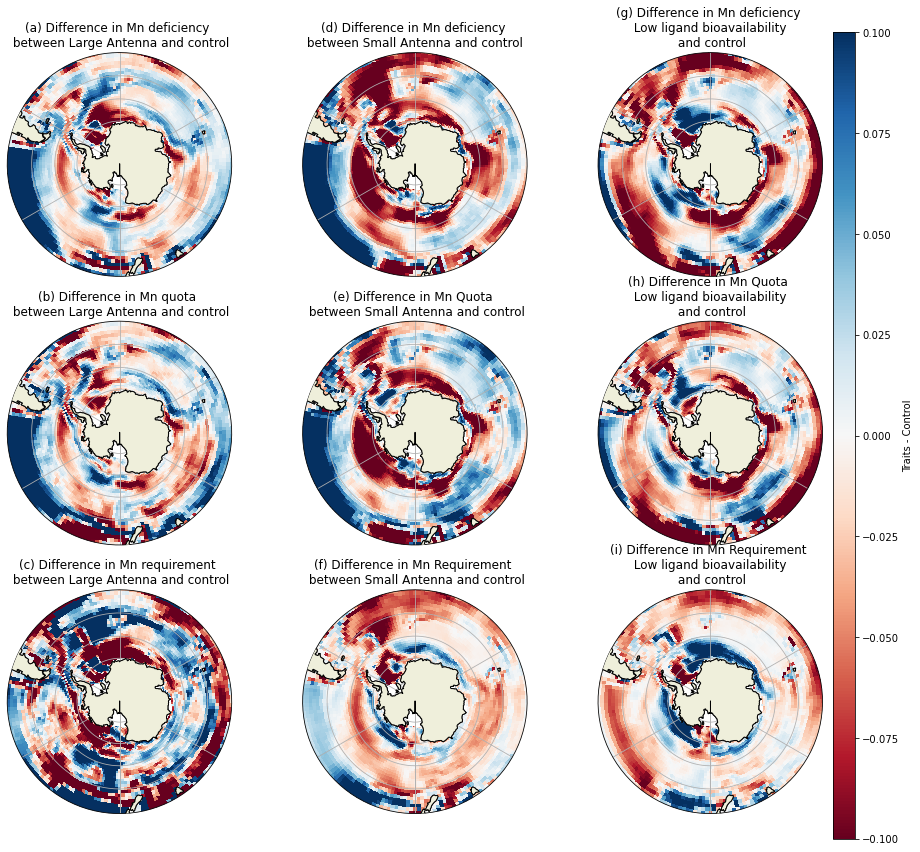

In [22]:
# Generate supplementary Figure S7 

fign= plt.figure(figsize=(15,14))
gridn= plt.GridSpec(3,3)
plt.rcParams.update({'font.size': 10})
fign.patch.set_facecolor('xkcd:white')
 
#blurb= [tqmnreqs,tqmns,mntotdef,qmnreqtot,mutot,tchlc]

#For control model
ccm= ccms[0]
refm= refms[0]

# Calculate Mn Req manually
reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

# Calculate Mn deficiency
mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))

diffmn= mndefcc-mndefref # deficiency difference

sinyalmn= (ccm[1]-refm[1])/reqref # Signal from Mn quota
sinyalmn2= (refm[1]/reqcc) - (refm[1]/reqref) # Signal from Mn requirement


# For Large antenna
ccm= ccms[1]
refm= refms[1]

reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))
diffmn1= mndefcc-mndefref # deficiency difference

sinyalmn1= (ccm[1]-refm[1])/reqref
sinyalmn21= (refm[1]/reqcc) - (refm[1]/reqref)

# Calculate the difference between control model and large antenna
ddiffmn= diffmn1-diffmn # difference between deficiency
dsinyalmn= sinyalmn1-sinyalmn # difference between Mn quota
dsinyalmn2= sinyalmn21-sinyalmn2 # difference between Mn requirement

ax1 = fign.add_subplot(gridn[0,0], projection=ccrs.SouthPolarStereo())
_a=ddiffmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(a) Difference in Mn deficiency \n between Large Antenna and control')

ax1 = fign.add_subplot(gridn[1,0], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',vmin=-.1, vmax=.1,   ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(b) Difference in Mn quota \n between Large Antenna and control')

ax1 = fign.add_subplot(gridn[2,0], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.025, vmax=.025,ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(c) Difference in Mn requirement \n between Large Antenna and control')


# For Small antenna
ccm= ccms[2]
refm= refms[2]

reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))
diffmn1= mndefcc-mndefref


sinyalmn1= (ccm[1]-refm[1])/reqref # QMn
sinyalmn21= (refm[1]/reqcc) - (refm[1]/reqref) #QMn, req


ddiffmn= diffmn1-diffmn
dsinyalmn= sinyalmn1-sinyalmn
dsinyalmn2= sinyalmn21-sinyalmn2

ax1 = fign.add_subplot(gridn[0,1], projection=ccrs.SouthPolarStereo())
_a=ddiffmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(d) Difference in Mn deficiency \n between Small Antenna and control ')

ax1 = fign.add_subplot(gridn[1,1], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',vmin=-.1, vmax=.1,   ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(e) Difference in Mn Quota \n between Small Antenna and control')

ax1 = fign.add_subplot(gridn[2,1], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1,ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(f) Difference in Mn Requirement \n between Small Antenna and control')

# For Low ligand bioavailability
ccm= ccms[3]
refm= refms[3]

reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))
diffmn1= mndefcc-mndefref


sinyalmn1= (ccm[1]-refm[1])/reqref
sinyalmn21= (refm[1]/reqcc) - (refm[1]/reqref)


ddiffmn= diffmn1-diffmn
dsinyalmn= sinyalmn1-sinyalmn
dsinyalmn2= sinyalmn21-sinyalmn2

ax1 = fign.add_subplot(gridn[0,2], projection=ccrs.SouthPolarStereo())
_a=ddiffmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(g) Difference in Mn deficiency \n Low ligand bioavailability \n and control')

ax1 = fign.add_subplot(gridn[1,2], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',vmin=-.1, vmax=.1,   ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(h) Difference in Mn Quota \n Low ligand bioavailability \n and control')

ax1 = fign.add_subplot(gridn[2,2], projection=ccrs.SouthPolarStereo())
_a=dsinyalmn2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1 ,ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(i) Difference in Mn Requirement \n Low ligand bioavailability \n and control')

# Plot colorbar
cb_ax = fign.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fign.colorbar(_a, cax=cb_ax)
cbar.ax.set_ylabel('Traits - Control')
fign.savefig('defi_signalmn_expt.png', dpi=100)

In [8]:
# calculate Fe deficiency

pfefile= ['ALLPFE_mnclim.nc', 'PFE_antentok.nc','PHYFE_asmalltok.nc','ALPFE_feplig.nc']
qfefile= ['QFEN_mnclim.nc', 'QFEN_antentok.nc','QFEN_asmalltok.nc','QFEN_feplig.nc']

filechl=['ALLCHL_mnclim.nc', 'ALLCHL_antentok.nc','ALLCHL_asmalltok.nc','ALLCHL_feplig.nc']

qopt= 10e-6
xcoef2 = 1.21E-5 * 14. / 55.85 / 7.625 * 0.5 * 1.5
xcoef3 = 1.15E-4 * 14. / 55.85 / 7.625 * 0.5

# xf is to calculate antenna size (CHL:PSU ratio, in PISCES it's PSU:CHL, 
# therefore 0.5 for large antenna and 2 for small antenna)

xf=[1,0.5,2,1] 

blurbfes=[]

qfes=[]
qfemins=[]
qfens=[]
chlcs=[]
fendefs=[]
for p, pf in enumerate(pfefile):
    pf= xr.open_dataset(pf)
    qf= xr.open_dataset(qfefile[p])
    dsc= xr.open_dataset(filechl[p])
    
    pfen= pf['NFe'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    pfed= pf['DFe'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    pfep= pf['PFe'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    # Iron requirement for nitrate reductase
    qfenn= qf['QFeNO3N'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    qfend= qf['QFeNO3D'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    qfenp= qf['QFeNO3P'].sel(deptht=4.999938e+00).where(pf['nav_lat']<-40).compute()
    
    qfens.append([qfenn,qfend,qfenp])
    
    xcoef1 = xf[p]*(0.00167 / 55.85)
    
    # Iron Quota
    qfen= pfen/phyns[p]
    qfed= pfed/phyds[p]
    qfep= pfep/phyps[p]
    
    qfes.append([qfen,qfed,qfep])
    chlcs.append([(chlns[p]/phyns[p]),(chlds[p]/phyds[p]),chlps[p]/phyps[p]])
    
    # Iron requirement for chlorophyll + nitrate reductase (qfen*)
    qfeminn= (xcoef1 * (chlns[p]/phyns[p])) + xcoef2 + qfenn
    qfemind= (xcoef1 * (chlds[p]/phyds[p])) + xcoef2 + qfend
    qfeminp= (xcoef1 * (chlps[p]/phyps[p])) + xcoef2 + qfenp
    
    qfemins.append([qfeminn,qfemind,qfeminp])
    
    # Iron requirement
    fendefn= (qfen-qfeminn)/qopt
    fendefp= (qfep-qfeminp)/qopt
    fendefd= (qfed-qfemind)/qopt
    
    fendefs.append([fendefn,fendefd,fendefp])
    
    fphyn= fracn[p]
    fphyd= fracd[p]
    fphyp= fracp[p]
    
    # Total iron deficiency
    fetotdef= (fendefn*fphyn)+(fendefp*fphyp)+(fendefd*fphyd)
    tqfereqs= (qfeminn*fphyn)+(qfemind*fphyd)+(qfeminp*fphyp) # QFe,req
    tqfes= (qfen*fphyn)+(qfed*fphyd)+(qfep*fphyp) # QFe
    tqchl= (fphyn*(xcoef1*(chln/phyn)))+(fphyd*(xcoef1*(chld/phyd)))+(fphyp*(xcoef1*(chlp/phyp))) #QFeChl:C
    tqnno3= (fphyn*qfenn)+(fphyd*qfend)+(fphyp*qfenp)# QFeNO3


    blurbfe=[tqfereqs,tqfes,fetotdef,tqchl,tqnno3]
    blurbfes.append(blurbfe)

In [10]:
orcagrid=xr.open_dataset('ORCA2.0.full_grid.nc')

In [11]:
feccms=[]
ferefms=[]

for ba in blurbfes:
    bb = ba
    ccm=[]
    refm=[]
    for b in bb:
        _ref= b.sel(time_counter=slice(yrs[0], yrs[1]))
        _cc= b.sel(time_counter=slice(yrscc[0], yrscc[1]))
        _refm= _ref.groupby('time_counter.month').mean('time_counter')
        _ccm= _cc.groupby('time_counter.month').mean('time_counter')
        ccm.append(_ccm[0])
        refm.append(_refm[0])
    feccms.append(ccm)
    ferefms.append(refm)

In [13]:
tak=blurbfes[0] # control model
feccma=[]
ferefma=[]
for b in tak:
    _ref= b.sel(time_counter=slice(yrs[0], yrs[1]))
    _cc= b.sel(time_counter=slice(yrscc[0], yrscc[1]))
    _refm= _ref.groupby('time_counter.month').mean('time_counter')
    _ccm= _cc.groupby('time_counter.month').mean('time_counter')
    feccma.append(_ccm[0])
    ferefma.append(_refm[0])

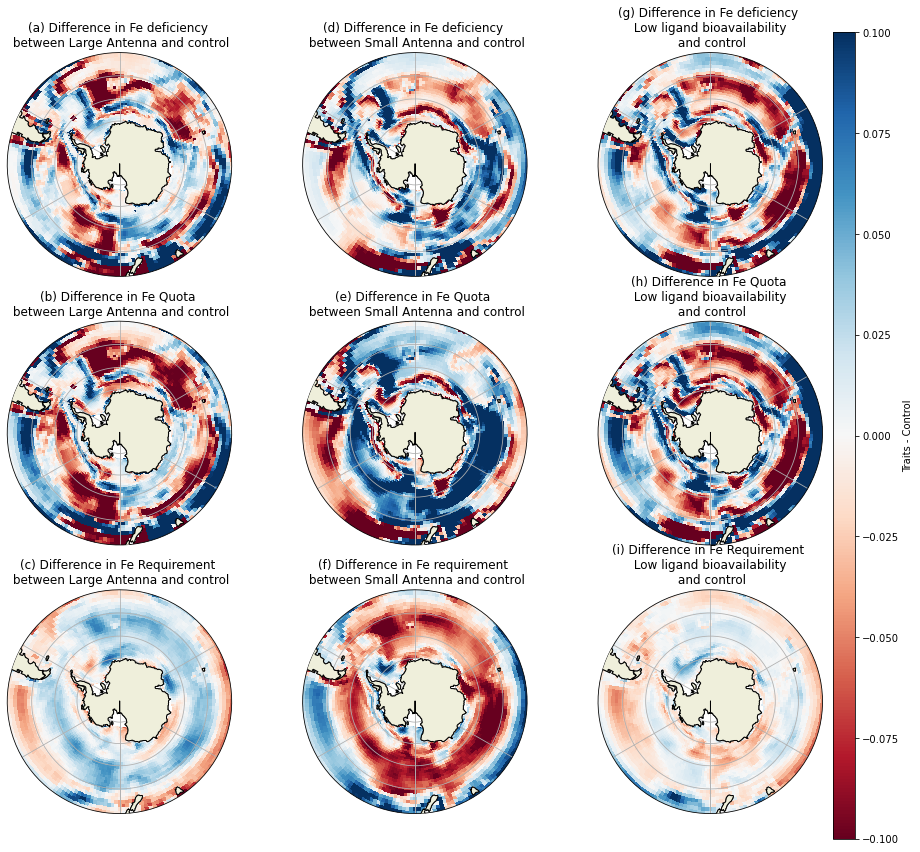

In [20]:
#Generate supplementary Figure S6

fign= plt.figure()
fign.set_size_inches(15,14)
gridn= plt.GridSpec(3,3)
plt.rcParams.update({'font.size': 10})
fign.patch.set_facecolor('xkcd:white')

#blurbfe=[tqfereqs,tqfes,fetotdef,tqchl,tqnno3]

## Control model ##
feccm=feccma
ferefm= ferefma

difffe0= feccm[2]-ferefm[2] # Difference in deficiency
sinyalfe0= (feccm[1]-ferefm[1])/qopt # Difference in iron quota
sinyalfe20= (ferefm[0]-feccm[0])/qopt # Difference in requirement

## Antenna Large ##
feccm=feccms[1]
ferefm= ferefms[1]

difffe1= feccm[2]-ferefm[2]
sinyalfe1= (feccm[1]-ferefm[1])/qopt
sinyalfe21= (ferefm[0]-feccm[0])/qopt

## Difference between antenna large and control model ##
ddifffe= difffe1-difffe0
dsinyalfe= sinyalfe1-sinyalfe0
dsinyalfe2= sinyalfe21-sinyalfe20

ax1 = fign.add_subplot(gridn[0,0], projection=ccrs.SouthPolarStereo())
_a=ddifffe.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(a) Difference in Fe deficiency \n between Large Antenna and control')

ax1 = fign.add_subplot(gridn[1,0], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(b) Difference in Fe Quota \n between Large Antenna and control')

ax1 = fign.add_subplot(gridn[2,0], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(c) Difference in Fe Requirement \n between Large Antenna and control')

## Antenna Small ##
feccm=feccms[2]
ferefm= ferefms[2]

difffe2= feccm[2]-ferefm[2]
sinyalfe2= (feccm[1]-ferefm[1])/qopt
sinyalfe22= (ferefm[0]-feccm[0])/qopt

ddifffe1= difffe2-difffe0
dsinyalfe1= sinyalfe2-sinyalfe0
dsinyalfe21= sinyalfe22-sinyalfe20

ax1 = fign.add_subplot(gridn[0,1], projection=ccrs.SouthPolarStereo())
_a=ddifffe1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(d) Difference in Fe deficiency \n between Small Antenna and control')

ax1 = fign.add_subplot(gridn[1,1], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(e) Difference in Fe Quota \n between Small Antenna and control')

ax1 = fign.add_subplot(gridn[2,1], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe21.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(f) Difference in Fe requirement \n between Small Antenna and control')


## Low ligand bioavailability ##

feccmo=feccms[3]
ferefmo= ferefms[3]

difffe3= feccmo[2]-ferefmo[2]
sinyalfe3= (feccmo[1]-ferefmo[1])/qopt
sinyalfe23= (ferefmo[0]-feccmo[0])/qopt


ddifffe2= difffe3-difffe0
dsinyalfe2= sinyalfe3-sinyalfe0
dsinyalfe22= sinyalfe23-sinyalfe20

ax1 = fign.add_subplot(gridn[0,2], projection=ccrs.SouthPolarStereo())
_a=ddifffe2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(g) Difference in Fe deficiency \n Low ligand bioavailability \n and control')


ax1 = fign.add_subplot(gridn[1,2], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(h) Difference in Fe Quota \n Low ligand bioavailability \n and control')

ax1 = fign.add_subplot(gridn[2,2], projection=ccrs.SouthPolarStereo())
_a=dsinyalfe22.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.1, vmax=.1, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(i) Difference in Fe Requirement \n Low ligand bioavailability \n and control')

cb_ax = fign.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fign.colorbar(_a, cax=cb_ax)
cbar.ax.set_ylabel('Traits - Control')
fign.savefig('defi_signal_expt.png', dpi=100)


NameError: name 'reqsmn1' is not defined

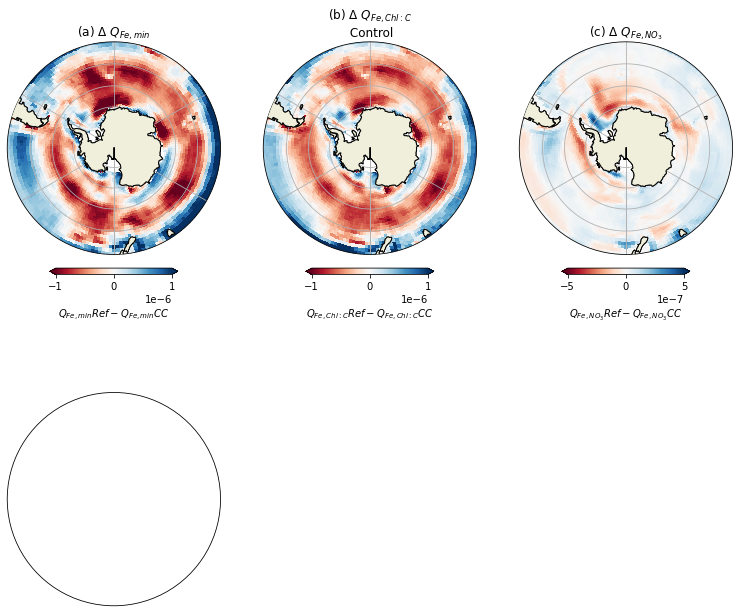

In [26]:
## Generate Supplementary Figure S5

fign= plt.figure(figsize=(13,11))
gridn= plt.GridSpec(2,3)

ferefm=ferefms[0]
feccm= feccms[0]
dfereq1=(ferefm[0]-feccm[0])
dtchl1=(ferefm[3]-feccm[3])
dtno31=(ferefm[4]-feccm[4])

f=0
ax1 = fign.add_subplot(gridn[f,0], projection=ccrs.SouthPolarStereo())
_a=dfereq1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-1e-6, vmax=1e-6, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(a) $\Delta$ $Q_{Fe,min}$')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel('\n'+'$Q_{Fe,min}Ref-Q_{Fe,min}CC$')

ax1 = fign.add_subplot(gridn[f,1], projection=ccrs.SouthPolarStereo())
_a=dtchl1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-1e-6, vmax=1e-6, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(b) $\Delta$ $Q_{Fe,Chl:C}$ \n Control')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel('\n'+'${Q_{Fe,Chl:C}Ref-Q_{Fe,Chl:C}CC}$')

ax1 = fign.add_subplot(gridn[f,2], projection=ccrs.SouthPolarStereo())
_a=dtno31.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu', ax=ax1, vmin=-0.5e-6, vmax=0.5e-6,  add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(c) $\Delta$ $Q_{Fe,NO_3}$')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel('\n'+'${Q_{Fe,NO_3}Ref-Q_{Fe,NO_3}CC}$')


ccm= ccms[0]
refm= refms[0]
    
reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))
diffmn1= mndefcc-mndefref # deficiency difference

reqsmn1=(reqref-reqcc)
delreq=reqcc-reqref

    mureq=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
    mucc=(1e-6+(4.97e-6*refm[5])*ccm[4]*86400)
    murs1= (mureq-mucc)

    reftchlc=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
    cctchlc=(1e-6+(4.97e-6*ccm[5])*refm[4]*86400)
    tchlcs1= (reftchlc-cctchlc)

ax1= fign.add_subplot(gridn[1,0], projection=ccrs.SouthPolarStereo())
_a=reqsmn1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu', ax=ax1, vmin=-2e-7, vmax=2e-7, add_colorbar=False, add_labels=False)
axku(ax1)
ci=plt.colorbar(_a, ax=ax1, extend='both',  orientation='horizontal', shrink=0.6, pad=0.05)
ax1.set_title('(d) $\Delta$ $Q_{Mn,min}$')     
ci.ax.set_xlabel('\n'+'$Q_{Mn,min}CC-Q_{Mn,min}Ref$')

ax1= fign.add_subplot(gridn[1,1], projection=ccrs.SouthPolarStereo())
_a=murs1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu', ax=ax1,vmin=-2e-7, vmax=2e-7, add_colorbar=False, add_labels=False)
axku(ax1)
ci=plt.colorbar(_a, ax=ax1, extend='both',  orientation='horizontal',shrink=0.6, pad=0.05)
ax1.set_title('(e) $\Delta \mu$')     
ci.ax.set_xlabel('\n'+'$\mu_{CC}-\mu_{Ref}$')
                 
ax1= fign.add_subplot(gridn[1,2], projection=ccrs.SouthPolarStereo())
_a=tchlcs1.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu', ax=ax1, vmin=-2e-7, vmax=2e-7,add_colorbar=False, add_labels=False)
axku(ax1)
ci=plt.colorbar(_a, ax=ax1, extend='both',  orientation='horizontal',shrink=0.6, pad=0.05)
ax1.set_title('(f) $\Delta$Chl:C')     
ci.ax.set_xlabel('\n'+'$Chl:C_{CC}-Chl:C_{Ref}$')

# fign.savefig('supplement_reqcontrol.png', dpi=200)

Text(0.5, 0, '$\\frac{Q_{Mn}Ref}{Q_{Mn,req}CC\\times \\mu Ref}-\\frac{Q_{Mn}Ref}{Q_{Mn,req}Ref\\times{\\mu}Ref}$')

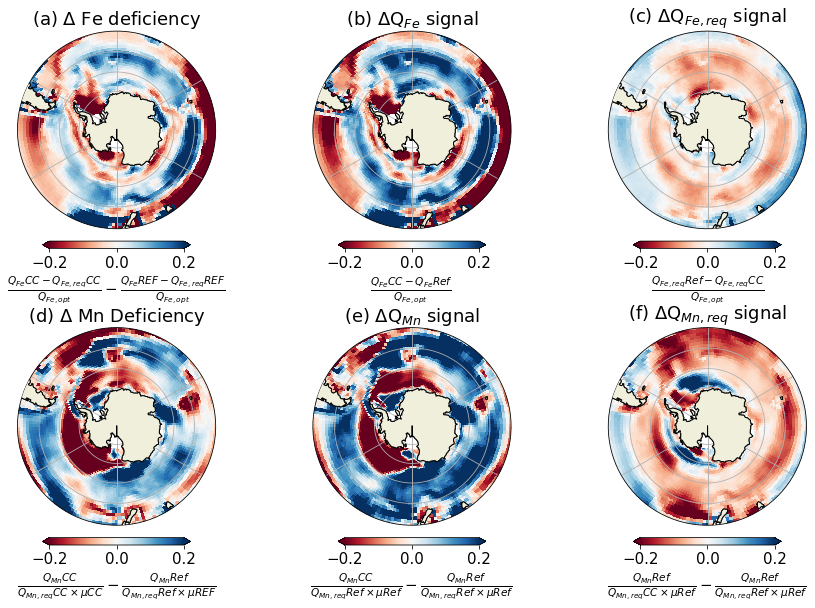

In [19]:


fign= plt.figure(figsize=(15,10))
gridn= plt.GridSpec(2,3)
plt.rcParams.update({'font.size': 15})
fign.patch.set_facecolor('xkcd:white')


ferefm= ferefms[0]
feccm= feccms[0]

difffe= feccm[2]-ferefm[2]
sinyalfe= (feccm[1]-ferefm[1])/qopt
sinyalfe2= (ferefm[0]-feccm[0])/qopt

differeq=ferefm[0]-feccm[0]
difftchl=(feccm[3]-ferefm[3])/differeq
difftno3=(feccm[4]-ferefm[4])/differeq



ax1 = fign.add_subplot(gridn[0,0], projection=ccrs.SouthPolarStereo())
_a=difffe.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(a) $\Delta$ Fe deficiency')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Fe}CC-Q_{Fe,req}CC}{Q_{Fe,opt}}-\frac{Q_{Fe}REF-Q_{Fe,req}REF}{Q_{Fe,opt}}$')

ax1 = fign.add_subplot(gridn[0,1], projection=ccrs.SouthPolarStereo())
_a=sinyalfe.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(b) $\Delta$Q$_{Fe}$ signal')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Fe}CC-Q_{Fe}Ref}{Q_{Fe,opt}}$')

ax1 = fign.add_subplot(gridn[0,2], projection=ccrs.SouthPolarStereo())
_a=sinyalfe2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(c) $\Delta$Q$_{Fe,req}$ signal')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Fe,req}Ref-Q_{Fe,req}CC}{Q_{Fe,opt}}$')


# blurb= [tqmnreqs,tqmns,mntotdef,qmnreqtot,mutot,tchlc]


ccm= ccms[0]
refm= refms[0]

reqref=(1e-6+(4.97e-6*refm[5])*refm[4]*86400)
reqcc=(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400)

mndefref= (refm[1]/(1e-6+(4.97e-6*refm[5])*refm[4]*86400))
mndefcc= (ccm[1]/(1e-6+(4.97e-6*ccm[5])*ccm[4]*86400))
diffmn= mndefcc-mndefref

diffchlc= (refm[1]/(1e-6+(4.97e-6*ccm[5])*refm[4]*86400)) - mndefref
diffmu= (refm[1]/(1e-6+(4.97e-6*refm[5])*ccm[4]*86400)) - mndefref


# blurb= [tqmnreqs,tqmns,mntotdef,mutot,tchlc]

sinyalmn= (ccm[1]-refm[1])/reqref
sinyalmn2= (refm[1]/reqcc) - (refm[1]/reqref)


ax1 = fign.add_subplot(gridn[1,0], projection=ccrs.SouthPolarStereo())

_a=diffmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(d) $\Delta$ Mn Deficiency')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Mn}CC}{Q_{Mn,req}CC \times \mu CC}-\frac{Q_{Mn}Ref}{Q_{Mn,req}Ref \times \mu REF}$')

ax1 = fign.add_subplot(gridn[1,1], projection=ccrs.SouthPolarStereo())
_a=sinyalmn.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(e) $\Delta$Q$_{Mn}$ signal')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Mn}CC}{Q_{Mn,req}Ref\times \mu Ref}-\frac{Q_{Mn}Ref}{Q_{Mn,req}Ref \times \mu Ref}$')

ax1 = fign.add_subplot(gridn[1,2], projection=ccrs.SouthPolarStereo())
_a=sinyalmn2.plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), cmap='RdBu',  vmin=-.2, vmax=.2, ax=ax1, add_colorbar=False, add_labels=False)
axku(ax1)
ax1.set_title('(f) $\Delta$Q$_{Mn,req}$ signal')
c=plt.colorbar(_a, ax=ax1, extend='both', shrink=0.6, orientation='horizontal', pad=0.05)
c.ax.set_xlabel(r'$\frac{Q_{Mn}Ref}{Q_{Mn,req}CC\times \mu Ref}-\frac{Q_{Mn}Ref}{Q_{Mn,req}Ref\times{\mu}Ref}$')
